In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import re
from scipy.optimize import fsolve
from astropy import constants as const
import emcee
import corner
import matplotlib.pyplot as plt

In [2]:
from tools import *
%load_ext autoreload
%autoreload 2

First, we will generate our data (radial velocity values) using a simulation!

Our model for the radial velocity of a star in a binary system is given by:
$$v(t) = \kappa[cos(f+\omega)+e \cos\omega + v_0$$
where
$$\kappa =\dfrac{(2\pi G)^{1/3}m\sin I}{T^{1/3}(M+m)^{2/3}\sqrt{1-e^2}}$$

$$tan(f/2)= \sqrt{\dfrac{1+e}{1-e}}\tan(u/2)$$

$$u-e\sin u = \dfrac{2\pi}{T}(t-\tau)$$

We generated values for our parameters based on our prior beliefs on allowed values of each, then calculated the radial velocity for each.

To generate values for the uncertainty, we want to determine what factors will influence the uncertainty value. We first looked for a correlation between radial velocity and uncertainty. Plotting the relationship between radial velocity and uncertainty for some sample systems, we get the following:

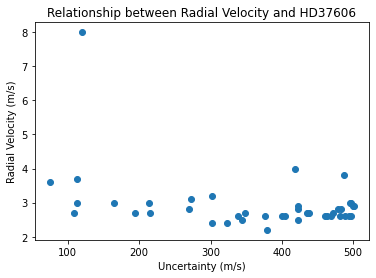

In [3]:
# selecting a random file from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files)-1)

plot_uncertainty_for_file(all_files[index])

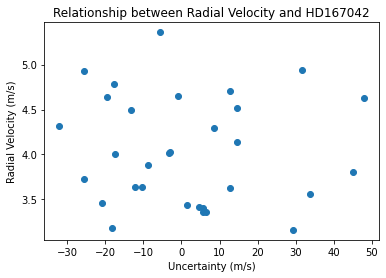

In [4]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

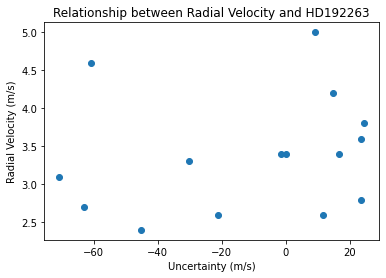

In [5]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

From the sample plots, there doesn't really seem to be a clear correlation between radial velocity and uncertainty. We can also plot all radial velocity values and uncertainties across all datasets:

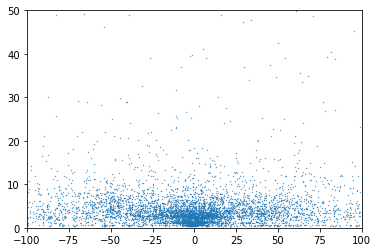

In [6]:
plot_uncertainty_correlation()

Since there really isn't an obvious correlation, we will assume that the value of radial velocity has no effect on the associated value of uncertainty. We will then assume that the instrument used will uniquely determine the uncertainty. For purposes of the simulation, we will draw randomly from the distribution of uncertainties of a selected instrument to obtain the uncertainty value for a given data point. Here is an example plot of the uncertainties of the SOPHIE instrument. 

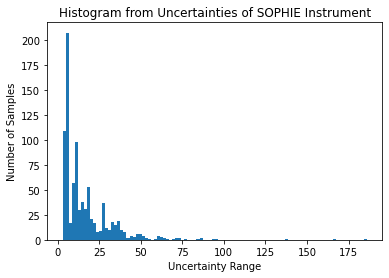

In [7]:
instrument = "SOPHIE"

uncertainties = get_uncertainties_instrument(instrument)
plot_instrumental_uncertainty_hist(instrument, bins=100)

In [21]:
sim_system = BinarySystem(num_points=50)

sim_system.initialize_mcmc(nwalkers=64)
sim_system.run_mcmc(num_iter=5000)
sim_system.save_samples()


/Users/nicolexu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 51%|███████████████████▉                   | 2554/5000 [01:22<01:10, 34.87it/s]/Users/nicolexu/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|███████████████████████████████████████| 5000/5000 [02:34<00:00, 32.27it/s]


In [25]:
sim_system.samples

array([[[ 8.74206539e+05,  9.68012217e-02,  1.37457695e+00,
          1.05346848e+01,  7.29888933e+00, -3.88787802e+03],
        [ 1.04199400e+05,  6.50067671e-01,  8.06926438e-01,
          9.39926701e+00,  9.01492078e+00, -7.24366193e+03],
        [-6.47917426e+05,  6.48333160e-01,  3.24569805e-01,
          5.00243797e+00,  4.29466100e+00,  1.99173707e+03],
        ...,
        [-2.86932580e+05,  7.34670745e-02,  1.32171167e+00,
          1.04346671e+01,  5.86211704e+00,  3.80374802e+03],
        [-3.33677646e+05,  6.88519553e-01,  2.05931336e-01,
          6.93664727e+00,  4.08296787e+00, -3.54654313e+03],
        [-2.35801658e+05,  3.39112379e-01,  3.72100453e-01,
          1.17712665e+01,  7.32796736e+00, -3.38989004e+03]],

       [[ 8.74206539e+05,  9.68012217e-02,  1.37457695e+00,
          1.05346848e+01,  7.29888933e+00, -3.88787802e+03],
        [-4.29968473e+04,  5.15446172e-01,  6.18677750e-01,
          1.04261739e+01,  8.28459007e+00, -5.57525312e+03],
        [-5.56711

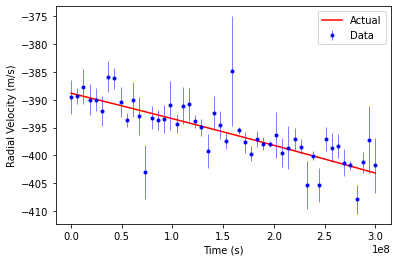

In [26]:
sim_system.plot_data(real=True)

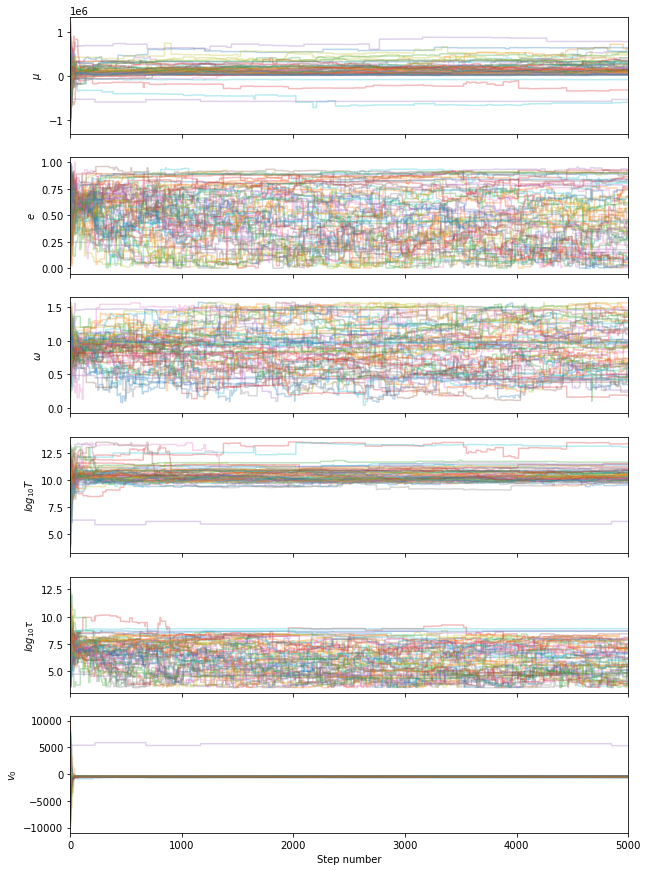

In [28]:
sim_system.trace()

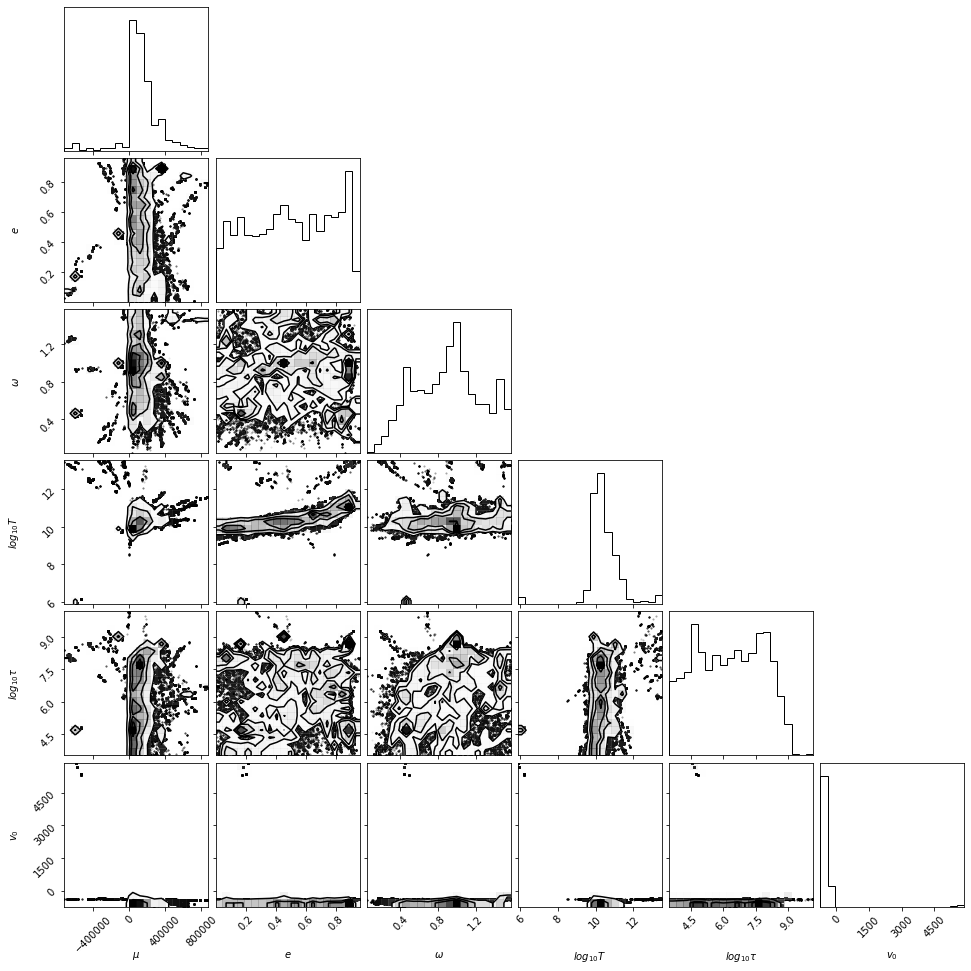

In [29]:
sim_system.corner()

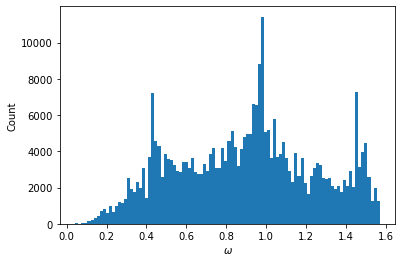

In [34]:
sim_system.param_hist_plot(2, bins=100)

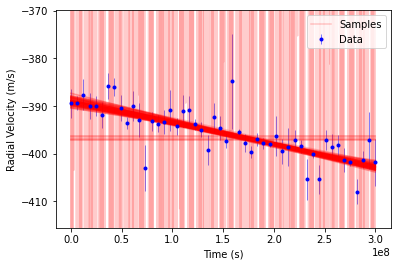

In [37]:
sim_system.plot_samples(num_samples=100)